# Test Results

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
import numpy as np
import random
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)           # For CPU
    torch.cuda.manual_seed(seed)      # For CUDA (if using GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)              # For NumPy
    random.seed(seed)                 # For Python's built-in random
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Turn off optimization for reproducibility

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet-5
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Datasets:\n\t-> TRAIN: {'available' if train_dataset else 'N/A'}\n\t-> TEST: {'available' if train_dataset else 'N/A'}")

Datasets:
	-> TRAIN: available
	-> TEST: available


In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 60000 samples
	-> TEST: 10000 samples


In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # kernel_size aka filter size
        # out_channels aka number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = torch.tanh(x) 
        # layer 2
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 3
        x = self.conv2(x)
        x = torch.tanh(x) 
        # layer 4
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 5
        x = self.conv3(x)
        x = torch.tanh(x) 
        # layer 6
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        # output layer
        x = self.fc2(x)
        # x = nn.functional.softmax(x, dim=1)  # remove softmax if using crossEntropy since it applies the softmax function too
    
        return x

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, new_updates=None, track_weights=False):
    model.train()
    train_loss = 0
    
    # Apply new updates to model weights if provided
    if new_updates is not None:
        with torch.no_grad():
            current_weights = {name: weights for name, weights in model.state_dict().items()}
            updated_weights = {name: current_weights[name] + new_updates[name].clone().detach()
                               for name in current_weights}
            model.load_state_dict(updated_weights)
    
    # Capture initial weights after applying new updates
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    
    # Capture updated weights after training
    w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    
    # Calculate weight updates
    weight_updates = {
        name: (w_t_plus_1[name] - w_t[name]) 
        for name in w_t
    }
    
    if track_weights:    
        # Save weight updates if tracking is on
        with open(f'save/LeNet5/updates_epoch_{epoch}.json', 'w') as json_file:
            json.dump(weight_updates, json_file)
            
    return weight_updates, avg_train_loss


In [8]:
def initialize_model(seed=42):
    set_seed(seed)
    model = LeNet5()
    return model

In [9]:
model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy

In [11]:
def flatten_vector(state_dict):
    flat_vector = []
    shapes = {}

    for name, tensor in state_dict.items():
        flattened_tensor = tensor.view(-1)  # Flatten the tensor into a 1D vector
        flat_vector.append(flattened_tensor)
        shapes[name] = tensor.shape  # Store the original shape

    # Concatenate all flattened tensors into a single 1D vector
    flat_vector = torch.cat(flat_vector)

    return flat_vector, shapes

In [12]:
def vector_to_state_dict(flat_vector, shapes):
    reconstructed_state_dict = {}
    current_index = 0

    for name, shape in shapes.items():
        # Calculate the number of elements in the tensor
        num_elements = torch.prod(torch.tensor(shape))
        # Extract the corresponding portion from the flat vector
        flattened_tensor = flat_vector[current_index:current_index + num_elements]
        # Reshape the 1D tensor back to its original shape
        tensor = flattened_tensor.view(shape)
        # Add the tensor back to the state_dict
        reconstructed_state_dict[name] = tensor
        # Update the current index
        current_index += num_elements

    return reconstructed_state_dict

In [13]:
class GA:
    def __init__(self, 
                 seed: int, 
                 d: int, 
                 q: int, 
                 device: torch.device = torch.device("cpu")) -> None:
        self.seed = seed
        self.d = d
        self.q = q
        self.device = device
        torch.manual_seed(self.seed)
        
        print(f'GA initialized with seed={seed}, d={d}, q={q}, device={device}')
        
    def G(self) -> torch.Tensor:
        return torch.rand(self.d, self.q).to(self.device)
    
    def w(self, delta: torch.Tensor) -> torch.Tensor:
        GT = self.G().t()  # Transpose the tensor
        return torch.matmul(GT, delta) / self.q
    
    def delta(self, w: torch.Tensor) -> torch.Tensor:
        return torch.matmul(self.G(), w)


In [14]:
def normalize(tensor: torch.Tensor, min_val: float = 0.0, max_val: float = 1.0) -> torch.Tensor:
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    
    # Scale tensor to range [0, 1]
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
    
    # Scale to desired range [min_val, max_val]
    normalized_tensor = normalized_tensor * (max_val - min_val) + min_val
    
    return normalized_tensor

In [15]:
num_epochs = 5

train_losses = []
test_losses = []
accuracies = []

for epoch in range(1, 1 + num_epochs):
    if epoch == 1:
        new_updates = None
    
    current_weights = {name: weights for name, weights in model.state_dict().items()}
    
    weight_updates, avg_train_loss = train(model=model, 
                                           device=device, 
                                           train_loader=train_loader, 
                                           optimizer=optimizer, 
                                           criterion=criterion, 
                                           epoch=epoch, 
                                           new_updates=new_updates,
                                           track_weights=False)
    real_delta, shapes = flatten_vector(weight_updates)
    seed = random.randint(0, 100)
    ga = GA(seed=seed,
            d=len(real_delta),
            q=100)
    w = ga.w(real_delta)
    approximated_delta = ga.delta(w)
    normalized_delta = normalize(tensor=approximated_delta,
                                 min_val=real_delta.min(),
                                 max_val=real_delta.max())
    new_updates = vector_to_state_dict(flat_vector=normalized_delta,
                                       shapes=shapes)
    
    updated_weights = {name: current_weights[name] + new_updates[name].clone().detach()
                               for name in current_weights}
        
    model.load_state_dict(updated_weights)
        
    
    avg_test_loss, accuracy = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [0/60000]	Loss: 2.306540
Train Epoch: 1 [6400/60000]	Loss: 0.202203
Train Epoch: 1 [12800/60000]	Loss: 0.471449
Train Epoch: 1 [19200/60000]	Loss: 0.070377
Train Epoch: 1 [25600/60000]	Loss: 0.287195
Train Epoch: 1 [32000/60000]	Loss: 0.180319
Train Epoch: 1 [38400/60000]	Loss: 0.106414
Train Epoch: 1 [44800/60000]	Loss: 0.342011
Train Epoch: 1 [51200/60000]	Loss: 0.484629
Train Epoch: 1 [57600/60000]	Loss: 0.438163
GA initialized with seed=45, d=61706, q=100, device=cpu

Test set: Average loss: 0.0017, Accuracy: 5579/10000 (56%)

Train Epoch: 2 [0/60000]	Loss: 7.067971
Train Epoch: 2 [6400/60000]	Loss: 0.668251
Train Epoch: 2 [12800/60000]	Loss: 0.495453
Train Epoch: 2 [19200/60000]	Loss: 0.417651
Train Epoch: 2 [25600/60000]	Loss: 0.404813
Train Epoch: 2 [32000/60000]	Loss: 0.511503
Train Epoch: 2 [38400/60000]	Loss: 0.303183
Train Epoch: 2 [44800/60000]	Loss: 0.404102
Train Epoch: 2 [51200/60000]	Loss: 0.321343
Train Epoch: 2 [57600/60000]	Loss: 0.334024
GA initialize

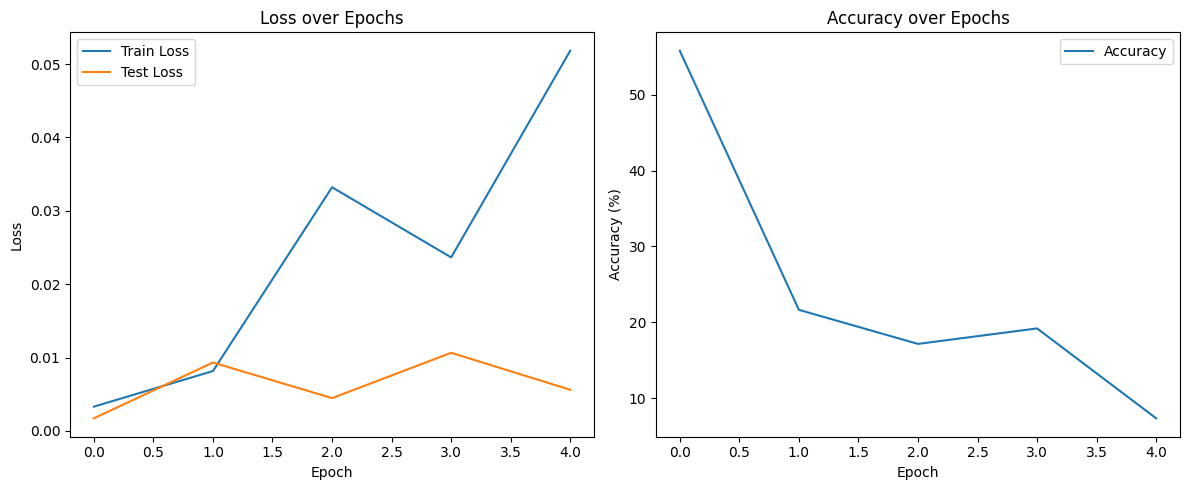

In [16]:
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Control Results

In [17]:
def train_control(model, device, train_loader, optimizer, criterion, epoch, track_weights=False):
    model.train()
    train_loss = 0
    
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    if track_weights:
        # Initialize to store the previous weights
        w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
        weight_updates = {
            name: (w_t[name] - w_t_plus_1[name]).tolist() 
            for name in w_t_plus_1
        }
        with open(f'save/LeNet5/updates_epoch_{epoch}.json', 'w') as json_file:
            json.dump(weight_updates, json_file)
    
    return avg_train_loss

In [18]:
model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
num_epochs = 5

control_train_losses = []
control_test_losses = []
control_accuracies = []

for epoch in range(1, 1 + num_epochs):
    avg_train_loss = train_control(model, device, train_loader, optimizer, criterion, epoch, track_weights=True)
    avg_test_loss, accuracy = test(model, device, test_loader)
    
    control_train_losses.append(avg_train_loss)
    control_test_losses.append(avg_test_loss)
    control_accuracies.append(accuracy)

Train Epoch: 1 [0/60000]	Loss: 2.306540
Train Epoch: 1 [6400/60000]	Loss: 0.202203
Train Epoch: 1 [12800/60000]	Loss: 0.471449
Train Epoch: 1 [19200/60000]	Loss: 0.070377
Train Epoch: 1 [25600/60000]	Loss: 0.287195
Train Epoch: 1 [32000/60000]	Loss: 0.180319
Train Epoch: 1 [38400/60000]	Loss: 0.106414
Train Epoch: 1 [44800/60000]	Loss: 0.342011
Train Epoch: 1 [51200/60000]	Loss: 0.484629
Train Epoch: 1 [57600/60000]	Loss: 0.438163

Test set: Average loss: 0.0001, Accuracy: 9625/10000 (96%)

Train Epoch: 2 [0/60000]	Loss: 0.097906
Train Epoch: 2 [6400/60000]	Loss: 0.079396
Train Epoch: 2 [12800/60000]	Loss: 0.186872
Train Epoch: 2 [19200/60000]	Loss: 0.071210
Train Epoch: 2 [25600/60000]	Loss: 0.032950
Train Epoch: 2 [32000/60000]	Loss: 0.166382
Train Epoch: 2 [38400/60000]	Loss: 0.008771
Train Epoch: 2 [44800/60000]	Loss: 0.080362
Train Epoch: 2 [51200/60000]	Loss: 0.059575
Train Epoch: 2 [57600/60000]	Loss: 0.108272

Test set: Average loss: 0.0001, Accuracy: 9639/10000 (96%)

Train Ep

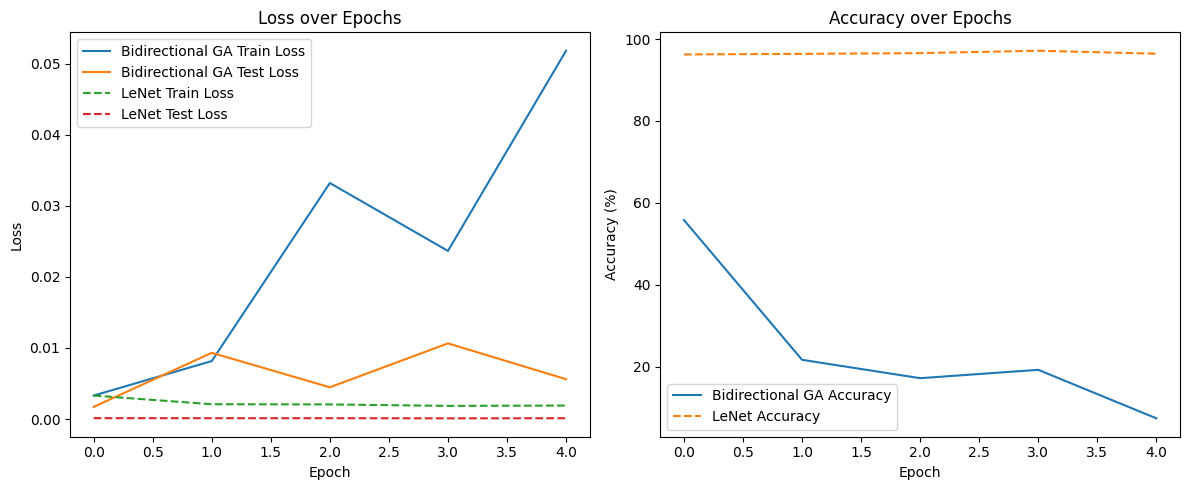

In [22]:
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Bidirectional GA Train Loss')
plt.plot(test_losses, label='Bidirectional GA Test Loss')
plt.plot(control_train_losses, label='LeNet Train Loss', linestyle='--')
plt.plot(control_test_losses, label='LeNet Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Bidirectional GA Accuracy')
plt.plot(control_accuracies, label='LeNet Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
